In [1]:
import sys, os
os.path.dirname(sys.executable)

'/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/bin'

In [2]:
sys.path.append('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/')
from ESMCBA.imports import *
from ESMCBA import graph_utils
from ESMCBA import other_utils
import importlib
importlib.reload(other_utils)

<module 'ESMCBA.other_utils' from '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/ESMCBA/other_utils.py'>

In [3]:
# evaluations_dt = other_utils.get_all_evaluations('/global/scratch/users/sergiomar10/losses/ESMCBA_21032025/*.csv')
# evaluations_dt.to_csv('../performances/models_performances_21032025.csv')
evaluations_dt = pd.read_csv('../performances/models_performances_21032025.csv', index_col=0)

In [4]:
evaluations_dt = evaluations_dt.sort_values(by='spearman', ascending = False).reset_index(drop=True)

In [6]:
evaluations_dt_sorted = evaluations_dt.drop_duplicates('HLA')
# evaluations_dt_sorted #.sort_values(by='mse', ascending = False, inplace = True)

In [147]:
merged_dfs_by_HLA = {}

# List to store combined metrics.
combined_metrics = []

# Define a helper function to compute PPV
def compute_ppv(y_true, y_pred, threshold=np.log10(500)):
    """
    Given a true affinity and predicted affinity (both in nM),
    compute the Positive Predictive Value (PPV).

    y_true <= threshold means a true binder;
    y_pred <= threshold means a predicted binder.
    """
    true_binders = (y_true <= threshold)
    pred_binders = (y_pred <= threshold)
    
    TP = np.logical_and(true_binders, pred_binders).sum()
    FP = np.logical_and(~true_binders, pred_binders).sum()
    
    if (TP + FP) == 0:
        return np.nan
    else:
        return TP / (TP + FP)

for HLA, path in evaluations_dt_sorted[['HLA', 'path']].values:
    try:
        formatted_HLA = HLA.replace('HLA', 'HLA-')
        replicate_spearman = []
        replicate_pearson = []
        replicate_ppv = []  # <--- PPV across replicates for Fine-tuned ESMC
        
        # Get all replicate CSV files using a glob pattern derived from 'path'
        file_paths = glob.glob(f'{path[:155]}*')
        print(f"{len(file_paths)} replicates for {formatted_HLA}")

        # Load the MHC Flurry predictions (assumed constant per HLA)
        mhc_pred = pd.read_csv(
            f'/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/performances/benchmark/MHCFlurry{formatted_HLA}_mhc_flurry.csv'
        )
        label = formatted_HLA

        # Loop over each replicate CSV file for the fine-tuned ESMC predictions
        for rep_path in file_paths:
            last_csv = pd.read_csv(rep_path)

            # Adjust the sequence if needed
            if len(last_csv['sequence'].iloc[0]) > 300:
                last_csv['sequence'] = last_csv['sequence'].apply(lambda x: x[365:])
                merged_df = pd.merge(last_csv, mhc_pred, left_on='sequence', right_on='peptide', how='left')
                # Fallback if the slicing didn't match any peptides
                if merged_df['peptide'].notna().sum() == 0:
                    last_csv = pd.read_csv(rep_path)
                    last_csv['sequence'] = last_csv['sequence'].apply(lambda x: x[362:])
                    merged_df = pd.merge(last_csv, mhc_pred, left_on='sequence', right_on='peptide', how='left')
            else:
                merged_df = pd.merge(last_csv, mhc_pred, left_on='sequence', right_on='peptide', how='left')

            # Compute log-transformed MHC affinity (for MHC Flurry) and filter out rows with missing values
            merged_df['mhc_log'] = merged_df['mhcflurry_affinity'].apply(np.log10)
            merged_df = merged_df[merged_df['mhc_log'].notna()]

            # -----------------
            # Compute correlation metrics for Fine-tuned ESMC
            # -----------------
            sp, _ = spearmanr(merged_df['measured'], merged_df['prediction'])
            pr, _ = pearsonr(merged_df['measured'], merged_df['prediction'])
            replicate_spearman.append(sp)
            replicate_pearson.append(pr)

            # -----------------
            # Compute PPV for Fine-tuned ESMC
            # Here we assume both 'measured' and 'prediction' are in nM
            # so that <= 500 means "binder".
            # -----------------
            ppv_val = compute_ppv(merged_df['measured'], merged_df['prediction'])
            replicate_ppv.append(ppv_val)

        # Store the last merged_df for reference (or you could store all replicates if desired)
        merged_dfs_by_HLA[formatted_HLA] = merged_df

        # Compute mean and standard deviation across replicates for Fine-tuned ESMC
        esmc_sp_mean = np.mean(replicate_spearman) if replicate_spearman else np.nan
        esmc_sp_std  = np.std(replicate_spearman)  if replicate_spearman else np.nan
        esmc_pr_mean = np.mean(replicate_pearson)  if replicate_pearson else np.nan
        esmc_pr_std  = np.std(replicate_pearson)   if replicate_pearson else np.nan

        # Compute mean and std of PPV across replicates
        esmc_ppv_mean = np.mean(replicate_ppv) if replicate_ppv else replicate_ppv[0]
        esmc_ppv_std  = np.std(replicate_ppv)  if replicate_ppv else replicate_ppv[0]

        # Append the Fine-tuned ESMC metrics with error bars
        combined_metrics.append({
            'HLA': formatted_HLA,
            'model': 'Fine-tuned ESMC',
            'label': label,
            'spearman': esmc_sp_mean,
            'spearman_std': esmc_sp_std,
            'pearson': esmc_pr_mean,
            'pearson_std': esmc_pr_std,
            'ppv': esmc_ppv_mean,
            'ppv_std': esmc_ppv_std
        })

        # -----------------
        # Compute correlation metrics for MHC Flurry using the last replicate's merged predictions
        # -----------------
        sp_mhc, _ = spearmanr(merged_df['measured'], merged_df['mhc_log'])
        pr_mhc, _ = pearsonr(merged_df['measured'], merged_df['mhc_log'])

        # MHC Flurry PPV (single run, so no replicate averaging)
        # We compare 'measured' (true) vs. 'mhcflurry_affinity' (predicted) at the same 500 nM threshold
        mhc_flurry_ppv = compute_ppv(merged_df['measured'], merged_df['mhc_log'])

        combined_metrics.append({
            'HLA': formatted_HLA,
            'model': 'MHC Flurry',
            'label': label,
            'spearman': sp_mhc,
            'spearman_std': 0,  # Single CSV file: no replicate standard deviation
            'pearson': pr_mhc,
            'pearson_std': 0,
            'ppv': mhc_flurry_ppv,
            'ppv_std': 0
        })

    except Exception as e:
        print(f"Error processing {HLA}: {e}")

# Create a dataframe with the combined metrics
combined_df = pd.DataFrame(combined_metrics)


2 replicates for HLA-A1101
2 replicates for HLA-A3001
2 replicates for HLA-A0203
1 replicates for HLA-A0206
Error processing HLAA0206: [Errno 2] No such file or directory: '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/performances/benchmark/MHCFlurryHLA-A0206_mhc_flurry.csv'
2 replicates for HLA-A0202
1 replicates for HLA-A6801
2 replicates for HLA-B3501
1 replicates for HLA-A2301
Error processing HLAA2301: [Errno 2] No such file or directory: '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/performances/benchmark/MHCFlurryHLA-A2301_mhc_flurry.csv'
2 replicates for HLA-B1517
1 replicates for HLA-B3901
Error processing HLAB3901: [Errno 2] No such file or directory: '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/performances/benchmark/MHCFlurryHLA-B3901_mhc_flurry.csv'
3 replicates for HLA-A3002
1 replicates for HLA-B5801
3 replicates for HLA-A2403
1 replicates for HLA-A6802
1 replicates for HLA-B0702
1 replicates for HLA-A0201
2 replicates for HLA-A3301
1 replicates for HLA-A2902
1

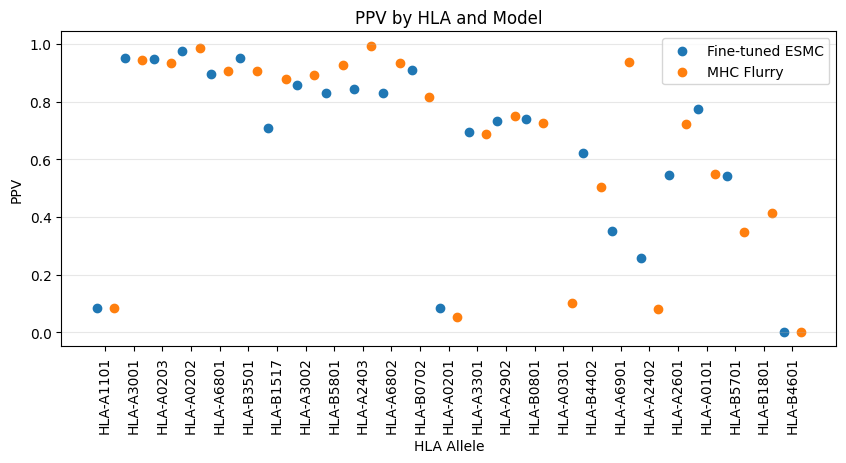

In [149]:
def plot_ppv_side_by_side(combined_df):
    # Extract unique categories for HLA and model.
    unique_HLA = combined_df['HLA'].unique()
    unique_models = combined_df['model'].unique()
    
    # Set up the figure size (adjust as needed).
    plt.figure(figsize=(10, 5))
    
    # We'll place each category (HLA) on an integer tick: 0, 1, 2, ...
    x_positions = np.arange(len(unique_HLA))
    
    # Compute horizontal offsets so each model is scattered side-by-side at each x-position.
    # For example, if there are 3 models, offsets might be [-0.2, 0.0, 0.2].
    n_models = len(unique_models)
    offsets = np.linspace(-0.3, 0.3, n_models)
    
    # Loop over each model and plot points with a distinct horizontal offset
    for offset, model in zip(offsets, unique_models):
        # Filter rows for this specific model
        subset = combined_df[combined_df['model'] == model]
        
        x_vals = []
        y_vals = []
        
        # Collect the PPV values for each HLA in the correct x-position
        for i, hla in enumerate(unique_HLA):
            # Subset further by HLA
            hla_subset = subset[subset['HLA'] == hla]
            # It's possible there are multiple rows per HLA if you store replicate info differently
            # so we plot them all. If there's only one row, it will simply add one point.
            for ppv_val in hla_subset['ppv'].values:
                x_vals.append(i + offset)
                y_vals.append(ppv_val)
        
        # Plot these points for the current model
        plt.scatter(x_vals, y_vals, label=model)
    
    # Set the x-ticks to the integer positions and label them with the HLA names
    plt.xticks(x_positions, unique_HLA, rotation=90)
    
    # Add some spacing at the bottom if labels are long
    plt.subplots_adjust(bottom=0.25)
    
    # Add labels and title
    plt.xlabel("HLA Allele")
    plt.ylabel("PPV")
    plt.title("PPV by HLA and Model")
    
    # Optionally add a light grid on the y-axis for clarity
    plt.grid(axis='y', alpha=0.3)
    
    # Add a legend
    plt.legend()
    
    # Show the figure
    plt.show()

# Example usage:
plot_ppv_side_by_side(combined_df)


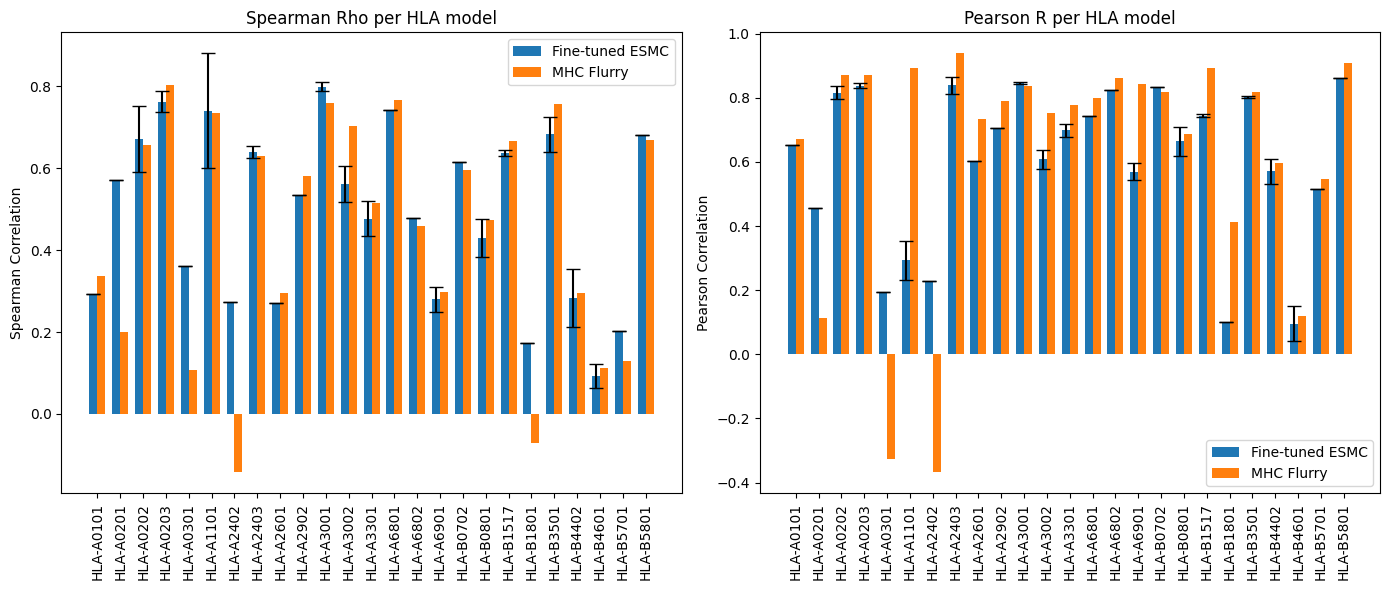

In [112]:
# Pivot the combined DataFrame to get values (and error bars) per HLA and model.
pivot_spearman     = combined_df.pivot(index='HLA', columns='model', values='spearman')
pivot_spearman_std = combined_df.pivot(index='HLA', columns='model', values='spearman_std')
pivot_pearson      = combined_df.pivot(index='HLA', columns='model', values='pearson')
pivot_pearson_std  = combined_df.pivot(index='HLA', columns='model', values='pearson_std')

# X-axis positions for each HLA.
x = np.arange(len(pivot_spearman.index))
width = 0.35  # width for each bar

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Spearman correlations:
# - Fine-tuned ESMC: with error bars from the aggregated data.
# - MHC Flurry: without error bars.
axes[0].bar(x - width/2, pivot_spearman['Fine-tuned ESMC'], width, 
            yerr=pivot_spearman_std['Fine-tuned ESMC'], capsize=5, label='Fine-tuned ESMC')
axes[0].bar(x + width/2, pivot_spearman['MHC Flurry'], width, label='MHC Flurry')
axes[0].set_xticks(x)
axes[0].set_xticklabels(pivot_spearman.index, rotation=90)
axes[0].set_ylabel('Spearman Correlation')
axes[0].set_title('Spearman Rho per HLA model')
axes[0].legend()

# Plot Pearson correlations:
# - Fine-tuned ESMC: with error bars from the aggregated data.
# - MHC Flurry: without error bars.
axes[1].bar(x - width/2, pivot_pearson['Fine-tuned ESMC'], width,
            yerr=pivot_pearson_std['Fine-tuned ESMC'], capsize=5, label='Fine-tuned ESMC')
axes[1].bar(x + width/2, pivot_pearson['MHC Flurry'], width, label='MHC Flurry')
axes[1].set_xticks(x)
axes[1].set_xticklabels(pivot_pearson.index, rotation=90)
axes[1].set_ylabel('Pearson Correlation')
axes[1].set_title('Pearson R per HLA model')
axes[1].legend()

plt.tight_layout()
plt.show()


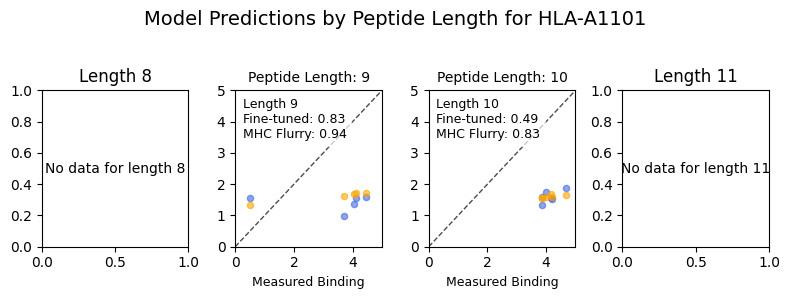

/tmp/ipykernel_1415938/3742307671.py:39: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_finetuned, _ = spearmanr(preds_length['measured'], preds_length['prediction'])
/tmp/ipykernel_1415938/3742307671.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_mhc, _       = spearmanr(preds_length['measured'], preds_length['mhc_log'])


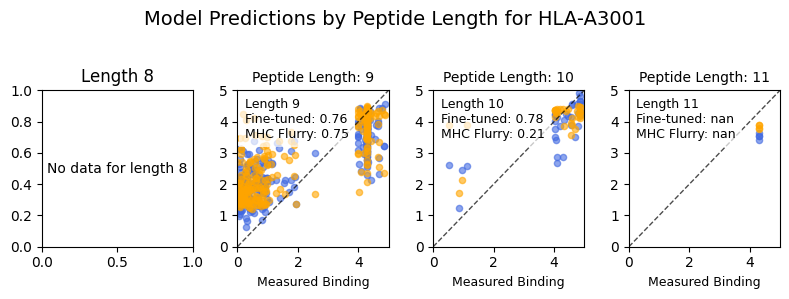

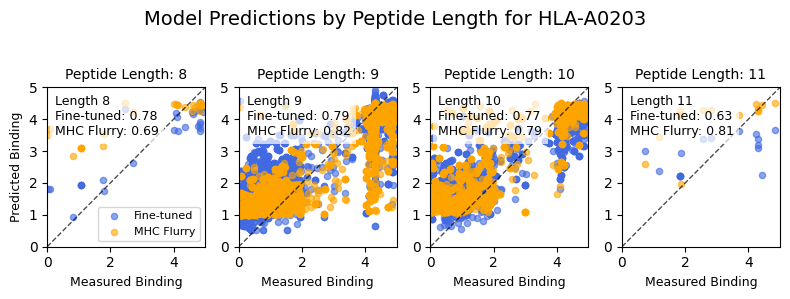

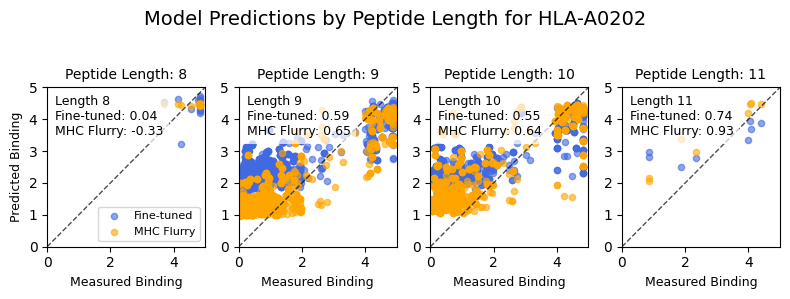

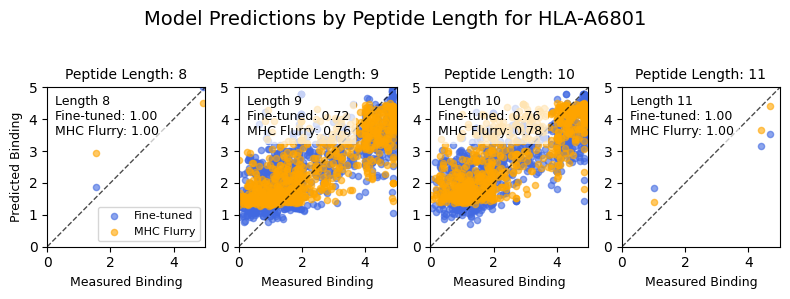

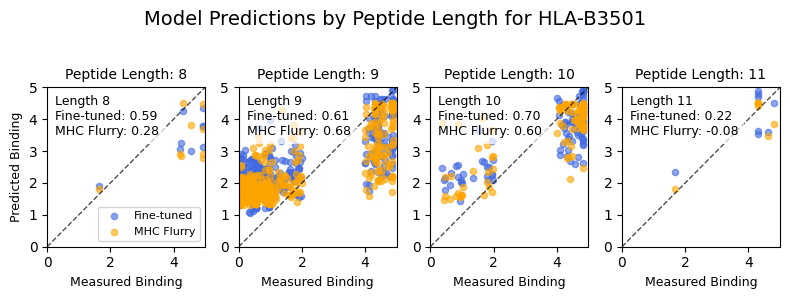

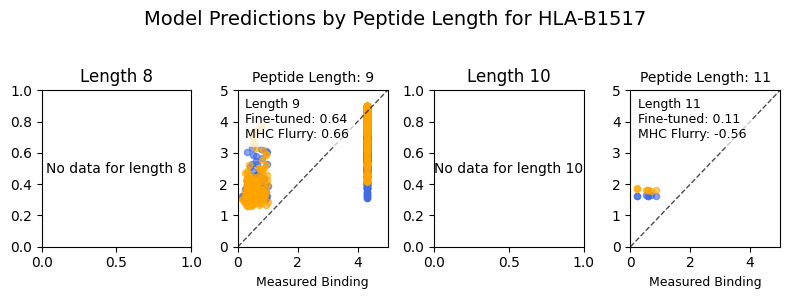

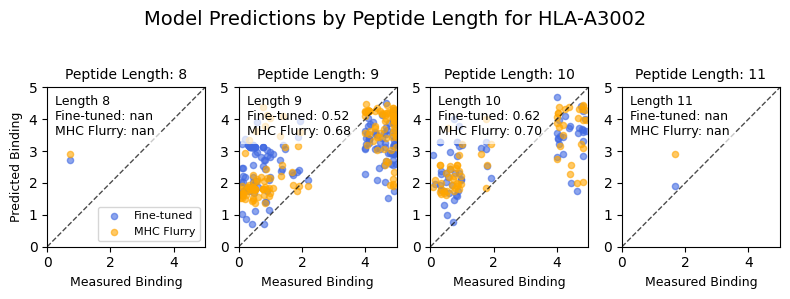

/tmp/ipykernel_1415938/3742307671.py:39: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_finetuned, _ = spearmanr(preds_length['measured'], preds_length['prediction'])
/tmp/ipykernel_1415938/3742307671.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_mhc, _       = spearmanr(preds_length['measured'], preds_length['mhc_log'])


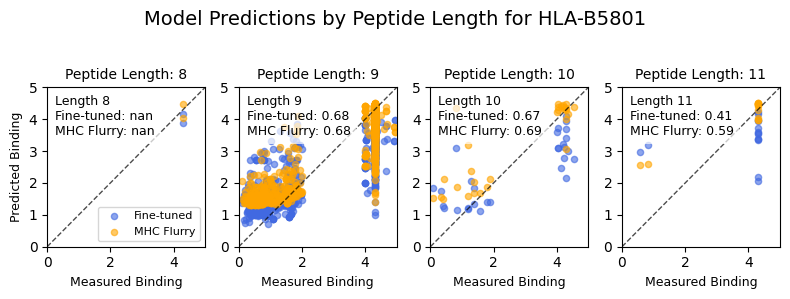

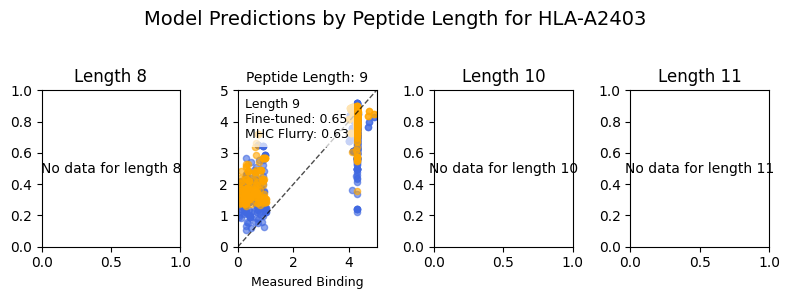

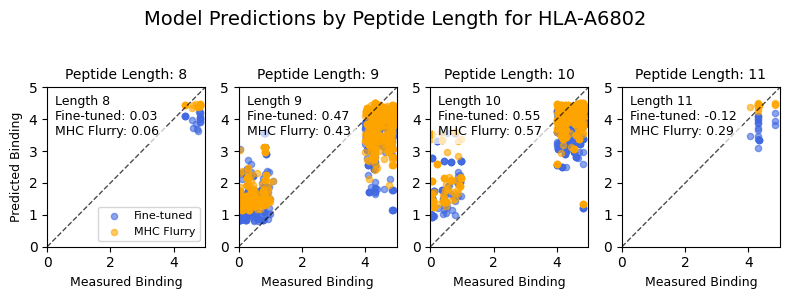

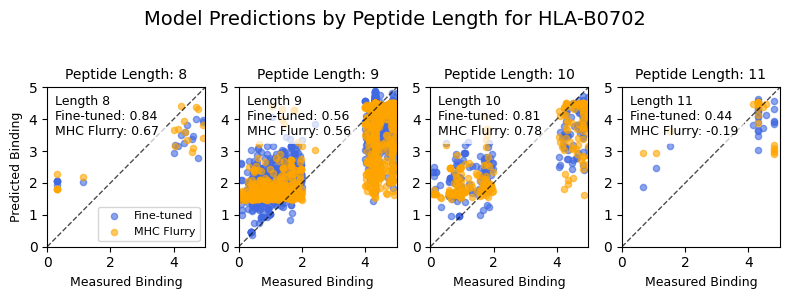

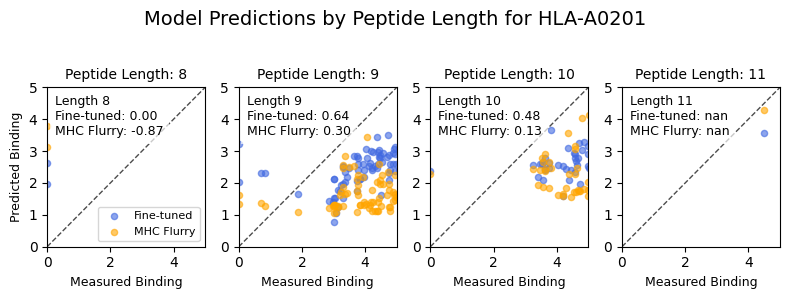

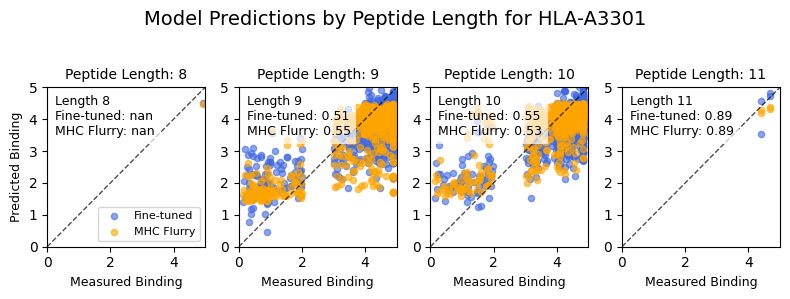

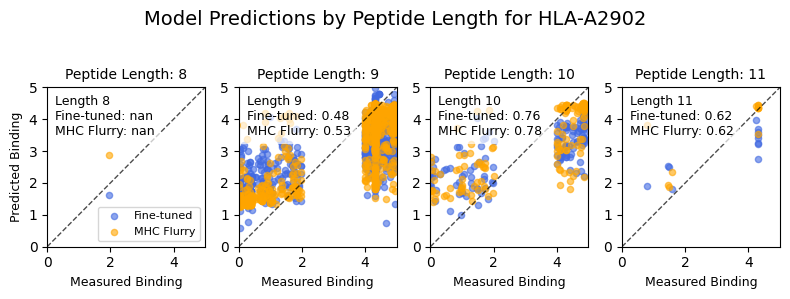

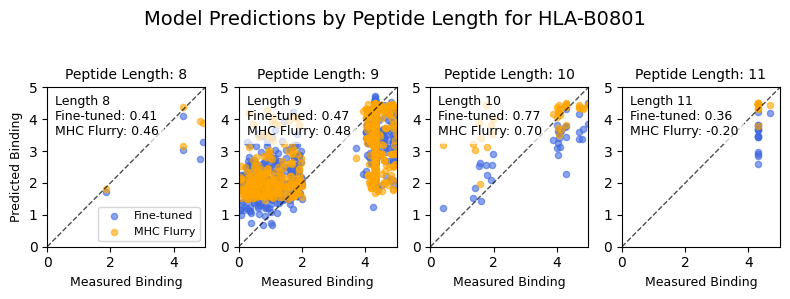

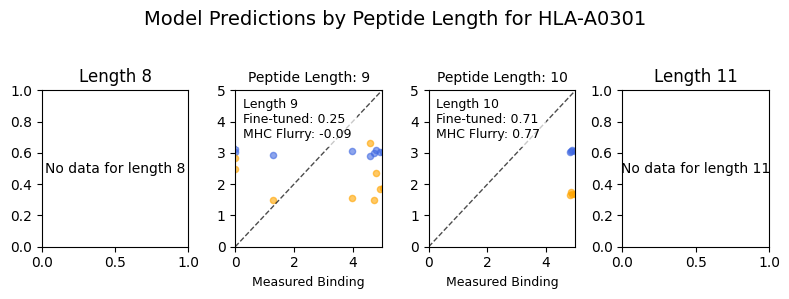

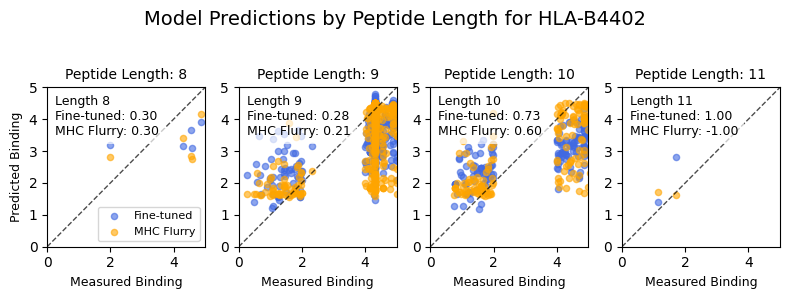

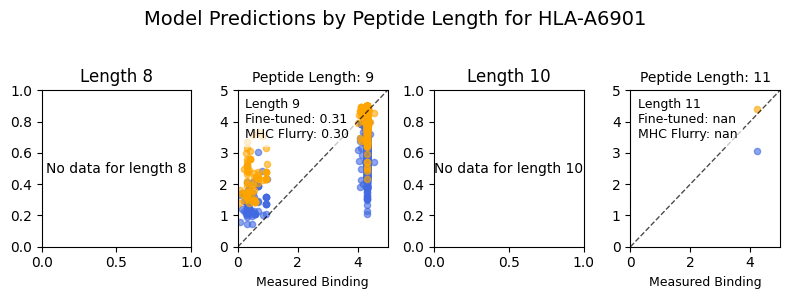

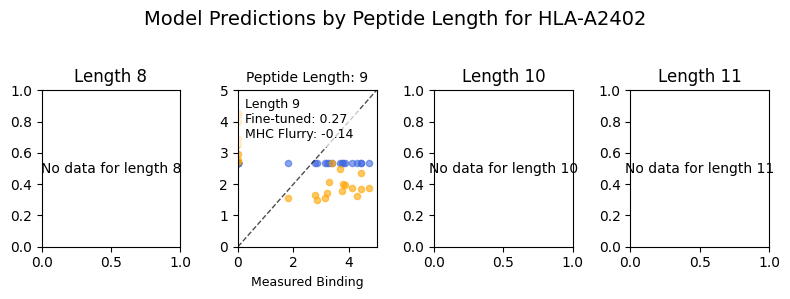

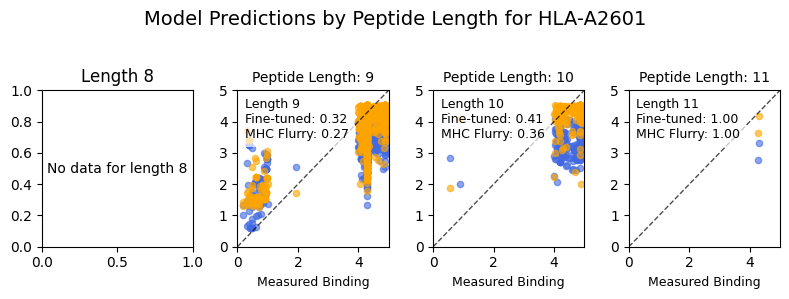

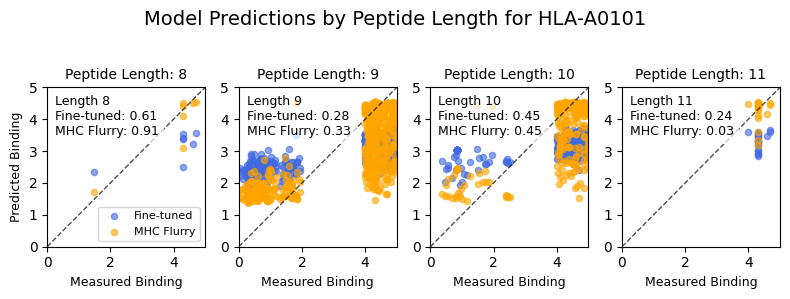

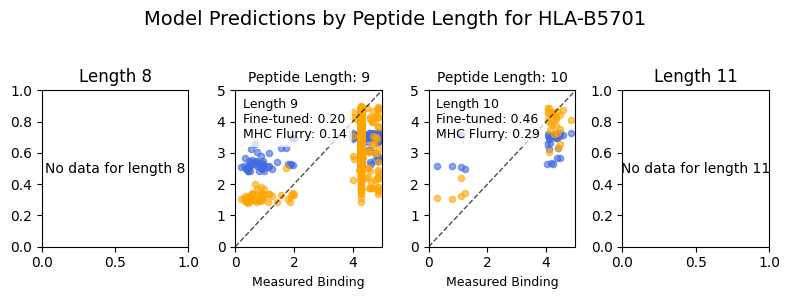

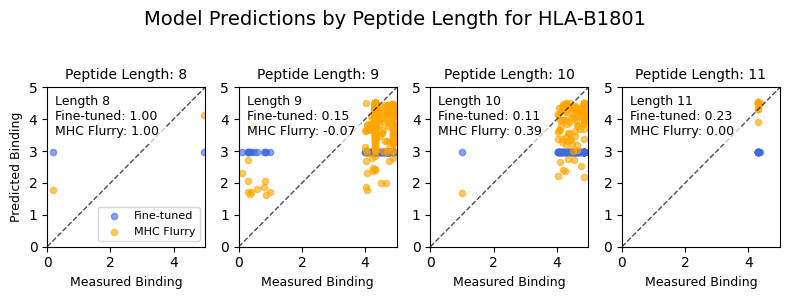

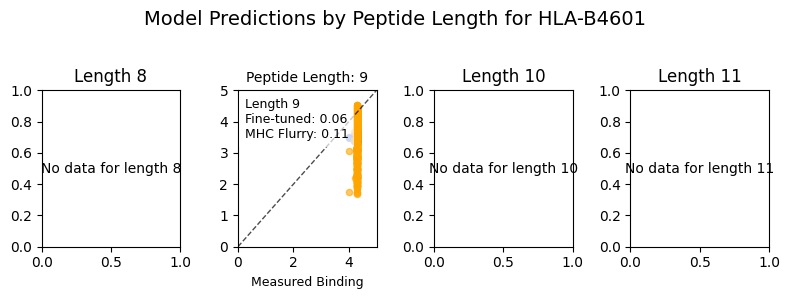

In [113]:
for HLA in merged_dfs_by_HLA.keys():

        predictions = merged_dfs_by_HLA[HLA]
        predictions['length'] = predictions['sequence'].str.len()
        
        fig, axes = plt.subplots(1, 4, figsize=(8, 3), sharex=False, sharey=False)
        
        # Loop over the four peptide lengths.
        for idx, L in enumerate([8, 9, 10, 11]):
            ax = axes[idx]
            preds_length = predictions[predictions['length'] == L]
            if preds_length.empty:
                ax.text(0.5, 0.5, f"No data for length {L}", ha='center', va='center')
                ax.set_title(f"Length {L}")
                continue
                
            # Scatter plots:
            # Fine-tuned predictions (assumed in column 'prediction')
            ax.scatter(preds_length['measured'], preds_length['prediction'], 
                       color='royalblue', alpha=0.6, s=20, label='Fine-tuned')
            # MHC Flurry predictions (log-transformed)
            ax.scatter(preds_length['measured'], preds_length['mhc_log'], 
                       color='orange', alpha=0.6, s=20, label='MHC Flurry')
            
            # Determine common limits for the x=y line.
            all_vals = np.concatenate([
                preds_length['measured'].values, 
                preds_length['prediction'].values,
                preds_length['mhc_log'].values
            ])
            min_val, max_val = np.min(all_vals), np.max(all_vals)
            pad = (max_val - min_val) * 0.05
            lims = [min_val - pad, max_val + pad]
            ax.plot([0,5], [0,5], 'k--', alpha=0.7, lw=1)
            ax.set_xlim([0,5])
            ax.set_ylim([0,5])
            
            # Compute Spearman correlations for each model.
            sp_finetuned, _ = spearmanr(preds_length['measured'], preds_length['prediction'])
            sp_mhc, _       = spearmanr(preds_length['measured'], preds_length['mhc_log'])
            
            # Annotate the panel with Spearman correlation values.
            annotation = (f"Length {L}\n"
                          f"Fine-tuned: {sp_finetuned:.2f}\n"
                          f"MHC Flurry: {sp_mhc:.2f}")
            ax.text(0.05, 0.95, annotation, transform=ax.transAxes,
                    verticalalignment='top', fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
            
            ax.set_title(f"Peptide Length: {L}", fontsize=10)
            if idx == 0:
                ax.set_ylabel("Predicted Binding", fontsize=9)
            ax.set_xlabel("Measured Binding", fontsize=9)
            if idx == 0:
                ax.legend(fontsize=8)
        
        fig.suptitle(f"Model Predictions by Peptide Length for {HLA}", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        
        # Save the figure with the HLA name in the specified folder.
        save_path = f'/global/scratch/users/sergiomar10/data/figures_presentation/{HLA}.png'
        # plt.savefig(save_path, dpi=300)
        # plt.close(fig)
        plt.show()
        